In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Dataset = "C:/Users/Abhishek/Downloads/Data"

In [3]:
files = os.listdir(Dataset)  # Print all folder/files in the given path
print(files)

['Almond', 'Ashoka', 'Bamboo', 'Berry', 'Hibisculus', 'Indian Laburnum', 'Mango', 'Neem', 'Pipal', 'Rose']


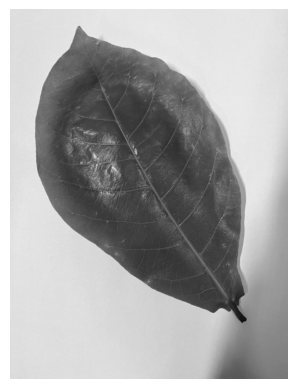

In [14]:
img_path = os.path.join(Dataset, files[0]) # Join the path with the folder name

image_file = os.listdir(img_path)
final_image_path = os.path.join(img_path, image_file[0])

img = cv2.imread(final_image_path)


img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show with matplotlib
plt.imshow(img_grey, cmap="gray")
plt.axis("off")
plt.show()

### Let's do image resize (First)

In [18]:
IMG_SIZE = (224, 224)

# Dictionary to store the images and labels of the dataset
resized_images ={}

# Saving image in current working directory
save_dir = os.path.join(os.getcwd(), "Resized_Data")
os.makedirs(save_dir, exist_ok=True)

In [19]:
# looping through entire dataset

for subfolder in os.listdir(Dataset):
    subfolder_path = os.path.join(Dataset, subfolder)

    images_list = []

    # Make corresponding subfolder in save_dir
    save_subfolder = os.path.join(save_dir, subfolder)
    os.makedirs(save_subfolder, exist_ok=True)

    for image in os.listdir(subfolder_path):

        image_path = os.path.join(subfolder_path, image)
        img = cv2.imread(image_path)

        if img is None:
            continue

        # first convert to gray scale then we will do resizing
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        resized = cv2.resize(gray, IMG_SIZE)

        # Save resized image
        save_path = os.path.join(save_subfolder, image)
        cv2.imwrite(save_path, resized)

        #Store in list
        images_list.append(resized)

    # Saving the resized image for future use case
    resized_images[subfolder] = images_list
    print(f"Processed {len(images_list)} images from {subfolder}")
    print(f"Saved resized images in folder: {save_subfolder}")

print("Done")

Processed 10 images from Almond
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Almond
Processed 10 images from Ashoka
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Ashoka
Processed 10 images from Bamboo
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Bamboo
Processed 10 images from Berry
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Berry
Processed 10 images from Hibisculus
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Hibisculus
Processed 10 images from Indian Laburnum
Saved resized images in folder: c:\Users\Abhishek\OneDrive\Desktop\AI_Coding_Scratch\Pattern_Recognition\Resized_Data\Indian Laburnum
Processed 10 images from Mango
Sav

In [20]:
del images_list
del resized_images

Read resized grayscale image

Gaussian Blur (reduce shadow noise)

Otsu Thresholding (separate leaf+paper vs background)

Morphological cleaning (open/close)

Resave cleaned images

In [ ]:
import pandas as pd

def compute_glcm(img, dx, dy, levels=16):
    """Compute Gray-Level Co-occurrence Matrix (GLCM) for a given offset."""
    h, w = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # Quantize image to given gray levels
    img = img // (256 // levels)

    for i in range(h):
        for j in range(w):
            ni = i + dy
            nj = j + dx
            if 0 <= ni < h and 0 <= nj < w:  # valid neighbor
                row = img[i, j]
                col = img[ni, nj]
                glcm[row, col] += 1

    if glcm.sum() > 0:
        glcm /= glcm.sum()
    return glcm


def haralick_features(gray, levels=16):
    """Compute 14 Haralick features from a grayscale image."""
    # Compute GLCM in four directions
    glcms = [
        compute_glcm(gray, 1, 0, levels),    # 0°
        compute_glcm(gray, 0, 1, levels),    # 90°
        compute_glcm(gray, 1, 1, levels),    # 45°
        compute_glcm(gray, -1, 1, levels)    # 135°
    ]

    # Average GLCM across directions
    glcm = np.mean(glcms, axis=0)

    i, j = np.indices(glcm.shape)
    mean_i = np.sum(i * glcm)
    mean_j = np.sum(j * glcm)
    std_i = np.sqrt(np.sum(((i - mean_i) ** 2) * glcm))
    std_j = np.sqrt(np.sum(((j - mean_j) ** 2) * glcm))

    # Haralick features
    features = []
    # 1. Angular Second Moment (Energy)
    features.append(np.sum(glcm ** 2))
    # 2. Contrast
    features.append(np.sum((np.abs(i - j) ** 2) * glcm))
    # 3. Correlation
    features.append(np.sum(((i - mean_i) * (j - mean_j) * glcm) / (std_i * std_j + 1e-10)))
    # 4. Sum of Squares: Variance
    features.append(np.sum(((i - mean_i) ** 2) * glcm))
    # 5. Inverse Difference Moment (Homogeneity)
    features.append(np.sum(glcm / (1 + (i - j) ** 2)))
    # 6. Sum Average
    px_plus_y = [np.sum(glcm[i + j == k]) for k in range(2 * levels)]
    features.append(np.sum([k * px_plus_y[k] for k in range(len(px_plus_y))]))
    # 7. Sum Variance
    mean_sum = features[-1]
    features.append(np.sum([((k - mean_sum) ** 2) * px_plus_y[k] for k in range(len(px_plus_y))]))
    # 8. Sum Entropy
    features.append(-np.sum([p * np.log2(p + 1e-10) for p in px_plus_y]))
    # 9. Entropy
    features.append(-np.sum(glcm * np.log2(glcm + 1e-10)))
    # 10. Difference Variance
    px_minus_y = [np.sum(glcm[np.abs(i - j) == k]) for k in range(levels)]
    mean_diff = np.sum([k * px_minus_y[k] for k in range(len(px_minus_y))])
    features.append(np.sum([((k - mean_diff) ** 2) * px_minus_y[k] for k in range(len(px_minus_y))]))
    # 11. Difference Entropy
    features.append(-np.sum([p * np.log2(p + 1e-10) for p in px_minus_y]))
    # 12. Info Measure of Correlation 1
    HX = -np.sum(np.sum(glcm, axis=1) * np.log2(np.sum(glcm, axis=1) + 1e-10))
    HY = -np.sum(np.sum(glcm, axis=0) * np.log2(np.sum(glcm, axis=0) + 1e-10))
    HXY = features[8]  # entropy
    HXY1 = -np.sum(glcm * np.log2(np.outer(np.sum(glcm, axis=1), np.sum(glcm, axis=0)) + 1e-10))
    features.append((HXY - HXY1) / max(HX, HY))
    # 13. Info Measure of Correlation 2
    features.append(np.sqrt(1 - np.exp(-2.0 * (HXY1 - HXY))))
    # 14. Max Correlation Coefficient (approx: largest eigenvalue of glcm*glcm)
    eigvals = np.linalg.eigvals(glcm @ glcm)
    features.append(np.max(np.real(eigvals)))

    return features



Dataset = "resized_data"   
output_csv = "haralick_features.csv"

records = []
for subfolder in os.listdir(Dataset):
    subfolder_path = os.path.join(Dataset, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    for image_name in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_name)
        gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if gray is None:
            continue

        features = haralick_features(gray)
        record = [f"{subfolder}/{image_name}"] + features
        records.append(record)

# Create DataFrame
columns = ["Image"] + [f"Feature_{i+1}" for i in range(14)]
df = pd.DataFrame(records, columns=columns)

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"Features extracted and saved to {output_csv}")

✅ Features extracted and saved to haralick_features.csv
